In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install lazypredict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Data wrangling
import pandas as pd
import numpy as np

# Data visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from lazypredict.Supervised import LazyRegressor

In [4]:
data = pd.read_csv("/content/drive/MyDrive/Phân tích số liệu/Data/student_score.xls", delimiter=",")

In [5]:
data.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [6]:
data

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75
...,...,...,...,...,...,...,...,...
995,female,group E,master's degree,standard,completed,88,99,95
996,male,group C,high school,free/reduced,none,62,55,55
997,female,group C,high school,free/reduced,completed,59,71,65
998,female,group D,some college,standard,completed,68,78,77


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


Text(0.5, 1.0, 'Distribution of Math Score')

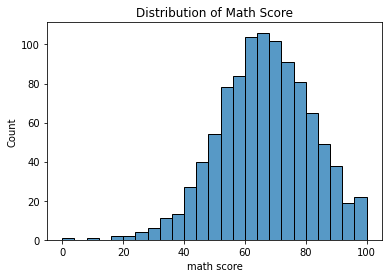

In [8]:
sns.histplot(data['math score'])
plt.title('Distribution of Math Score')

In [9]:
x = data.drop("math score", axis=1)
y = data["math score"]

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [11]:
# Scale numeric values
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # processing missing value
    ('scaler', StandardScaler())])

In [12]:
# Ordinal encode ordinal values
education_values = ['some high school', 'high school', 'some college', "associate's degree", "bachelor's degree",
                    "master's degree"]
gender_values = data["gender"].unique()
lunch_values = data["lunch"].unique()
prep_values = data["test preparation course"].unique()
ord_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OrdinalEncoder(categories=[education_values, gender_values, lunch_values, prep_values],
                              handle_unknown='use_encoded_value', unknown_value=-1))])


In [13]:
# One-hot encode nominal values
nom_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])


In [14]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num_features', num_transformer, ["reading score", "writing score"]),
        (
            'ord_features', ord_transformer,
            ["parental level of education", "gender", "lunch", "test preparation course"]),
        ('cat_features', nom_transformer, ["race/ethnicity"])])

In [15]:
# USE LINEAR REGRESSOR
# Train model
reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())])

reg.fit(x_train, y_train)
# Run prediction on test set
y_predict = reg.predict(x_test)

mae = mean_absolute_error(y_test, y_predict)
mse = mean_squared_error(y_test, y_predict)

print("Mean absolute error {}".format(mae))
print("Mean squared error {}".format(mse))



Mean absolute error 4.181966418321512
Mean squared error 28.82105656383289


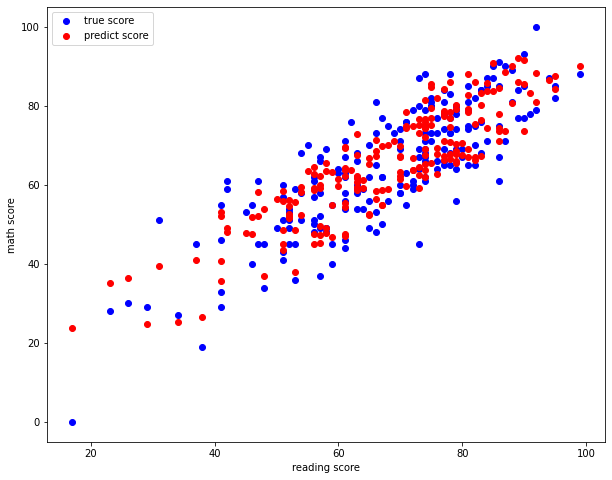

In [33]:
plt.figure(figsize = (10, 8))
plt.scatter(x_test["reading score"], y_test, c = "blue", edgecolors='blue', label = 'true score')
plt.scatter(x_test["reading score"], y_predict, c = "red", edgecolors='red', label = 'predict score')
plt.xlabel("reading score")
plt.ylabel("math score")
plt.legend()
plt.show()

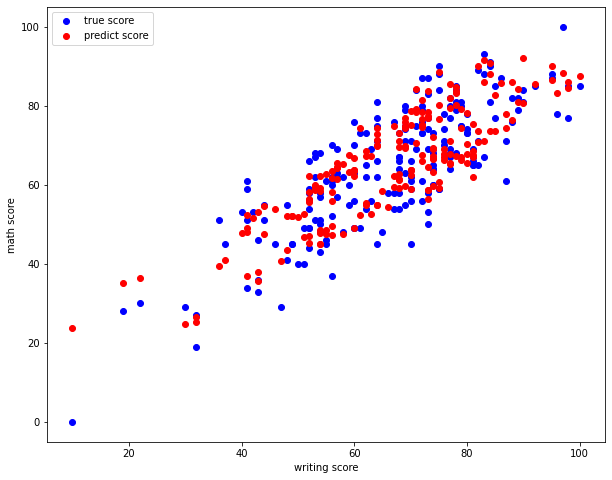

In [34]:
plt.figure(figsize = (10, 8))
plt.scatter(x_test["writing score"], y_test, c = "blue", edgecolors='blue', label = 'true score')
plt.scatter(x_test["writing score"], y_predict, c = "red", edgecolors='red', label = 'predict score')
plt.xlabel("writing score")
plt.ylabel("math score")
plt.legend()
plt.show()

In [16]:
# USE GridSearchCV (FOR SMALL DATASET)
reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())])


In [17]:
param_grid = {'regressor__n_estimators': [100, 200],
              'regressor__max_features': ['auto', 'sqrt'],
              'regressor__max_depth': [5, 10],
              'regressor__min_samples_split': [10, 50],
              'regressor__min_samples_leaf': [2, 5]}

In [18]:
grid_search = GridSearchCV(reg, param_grid=param_grid, cv=10)
grid_search.fit(x_train, y_train)
print("Best parameters: {}".format(grid_search.best_params_))
y_predict = grid_search.predict(x_test)

mae = mean_absolute_error(y_test, y_predict)
mse = mean_squared_error(y_test, y_predict)

print("GridSearchCV: Mean absolute error {}".format(mae))
print("GridSearchCV: Mean squared error {}".format(mse))

Best parameters: {'regressor__max_depth': 10, 'regressor__max_features': 'auto', 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 200}
GridSearchCV: Mean absolute error 4.5675005816851195
GridSearchCV: Mean squared error 36.075480197050815


In [19]:
# USE RandomizedSearchCV (FOR LARGE DATASET)
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=100, stop=1200, num=12)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [5, 10, 20, 30]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 50, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]

# Random search of parameters, using 5-fold cross validation, search across 100 different combinations

random_grid = {'regressor__n_estimators': n_estimators,
               'regressor__max_features': max_features,
               'regressor__max_depth': max_depth,
               'regressor__min_samples_split': min_samples_split,
               'regressor__min_samples_leaf': min_samples_leaf}

In [20]:
random_search = RandomizedSearchCV(estimator=reg, param_distributions=random_grid,
                        scoring='neg_mean_squared_error', n_iter=10, cv=5,
                        verbose=1, random_state=42, n_jobs=1)
random_search.fit(x_train, y_train)
print("Best parameters: {}".format(random_search.best_params_))
y_predict = random_search.predict(x_test)

mae = mean_absolute_error(y_test, y_predict)
mse = mean_squared_error(y_test, y_predict)

print("RandomizedSearchCV: Mean absolute error {}".format(mae))
print("RandomizedSearchCV: Mean squared error {}".format(mse))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'regressor__n_estimators': 100, 'regressor__min_samples_split': 10, 'regressor__min_samples_leaf': 2, 'regressor__max_features': 'auto', 'regressor__max_depth': 20}
RandomizedSearchCV: Mean absolute error 4.591577532398354
RandomizedSearchCV: Mean squared error 36.32651910232146


In [21]:
# SEARCH FOR ALL REGRESSORS
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(x_train, x_test, y_train, y_test)

print(models)

100%|██████████| 42/42 [00:14<00:00,  2.90it/s]

                               Adjusted R-Squared  R-Squared   RMSE  \
Model                                                                 
LassoLarsCV                                  0.88       0.88   5.33   
LassoLarsIC                                  0.88       0.88   5.34   
HuberRegressor                               0.88       0.88   5.37   
SGDRegressor                                 0.88       0.88   5.38   
LassoCV                                      0.88       0.88   5.38   
KernelRidge                                  0.88       0.88   5.38   
LinearSVR                                    0.88       0.88   5.39   
ElasticNetCV                                 0.88       0.88   5.39   
BayesianRidge                                0.88       0.88   5.39   
RidgeCV                                      0.88       0.88   5.39   
Ridge                                        0.88       0.88   5.39   
TransformedTargetRegressor                   0.88       0.88   5.39   
Linear